In [1]:
import execute
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import spearmanr, kstest

In [84]:
filepath = r'resultados_sergio\5minutos_3900_0.05_0.5_desligado_0.05_desligado_ligado.csv.pickle'

In [85]:
file = filepath[:-11].split('\\')[1].split('_')
dicionario = ['periodo', 'train_size', 'significancia', 'z_score_saida', 'z_score_stop', 'conf_var', 'usar_halflife', 'usar_var']
pd.DataFrame({'-':dicionario, '--':file})

,-,--
0,periodo,5minutos
1,train_size,3900
2,significancia,0.05
3,z_score_saida,0.5
4,z_score_stop,desligado
5,conf_var,0.05
6,usar_halflife,desligado
7,usar_var,ligado


In [86]:
with open(filepath, 'rb') as handle:
    dict_list = pickle.load(handle)

In [87]:
dict_list['return'].sum()

-5.555433980473059

In [88]:
def desfaz(df_antigo):
    
    d1_list = []
    
    closed = df_antigo.loc[df_antigo.status=='close']
    custos = 0.0071
    
    for row in closed.itertuples():
        
        d1 = df_antigo.loc[df_antigo.id == row.id]
        d1.set_index('date', inplace=True)
        aluguel = (1.0143)**((d1.iloc[-1].days_open+2)/252) -1
        
        if row.side == 'lower':
            
            d1.at[row.open_date, 'price_fst_stock'] =  d1.at[row.open_date, 'price_fst_stock'] / (1+0.0071)
            d1.at[row.open_date, 'price_scnd_stock'] = d1.at[row.open_date, 'price_scnd_stock'] / (1-0.0071)

            d1.at[row.date, 'price_fst_stock'] = d1.at[row.date, 'price_fst_stock'] / (1-custos)
            d1.at[row.date, 'price_scnd_stock'] = d1.at[row.date, 'price_scnd_stock'] / (1+(custos+aluguel))
            
        else:
            
            d1.at[row.open_date,'price_scnd_stock'] = d1.at[row.open_date,'price_scnd_stock'] / (1+0.0071)
            d1.at[row.open_date, 'price_fst_stock'] = d1.at[row.open_date, 'price_fst_stock'] / (1-0.0071)

            d1.at[row.date, 'price_scnd_stock'] = d1.at[row.date, 'price_scnd_stock'] / (1-custos)
            d1.at[row.date,'price_fst_stock'] = d1.at[row.date,'price_fst_stock'] / (1+(custos+aluguel))
            
        d1.at[row.open_date,'open_price_first_stock'] = d1.at[row.open_date, 'price_fst_stock']
        d1.at[row.open_date, 'open_price_scnd_stock'] = d1.at[row.open_date, 'price_scnd_stock']
        
        d1_list.append(d1)
        
    novo=pd.concat(d1_list)        
    novo.drop(columns=['ratio_sem_custos', 'ratio', 'return', 'retorno_acumulado', 'return_sem_custos', 'retorno_acumulado_sem_custos', 'side'], inplace=True)
    
    return novo

In [89]:
df_novo = desfaz(dict_list)

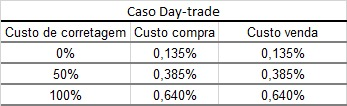

In [90]:
custo_baixo = execute.novo_retorno(df_novo.reset_index(), custo_compra=0.00135, custo_venda=0.00385, intraday=True)
custo_medio = execute.novo_retorno(df_novo.reset_index(), custo_compra=0.00385, custo_venda=0.00635, intraday=True)
custo_alto = execute.novo_retorno(df_novo.reset_index(), custo_compra=0.0064, custo_venda=0.0089, intraday=True)

C:\Users\willi\Documents\GitHub\cointegration\execute.py:326: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_returns = df_returns.set_index('open_date').loc['2019-01-01':]
C:\Users\willi\Documents\GitHub\cointegration\execute.py:326: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_returns = df_returns.set_index('open_date').loc['2019-01-01':]
C:\Users\willi\Documents\GitHub\cointegration\execute.py:326: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_returns = df_returns.set_index('open_date').loc['2019-01-01':]


In [91]:
dict_list['return'].sum()

-5.555433980473059

In [92]:
log_return_custo_baixo = np.log(1+custo_baixo.set_index('date').resample('1D')['return'].mean())
custo_baixo_return = np.exp(log_return_custo_baixo.cumsum()) -1

In [93]:
log_return_custo_medio = np.log(1+custo_medio.set_index('date').resample('1D')['return'].mean())
custo_medio_return = np.exp(log_return_custo_medio.cumsum()) -1

In [94]:
log_return_custo_alto = np.log(1+custo_alto.set_index('date').resample('1D')['return'].mean())
custo_alto_return = np.exp(log_return_custo_alto.cumsum()) -1

In [95]:
# Calcula retorno IBOV
ibov = pd.read_excel(r'ibov_historico.xlsx')
ibov.set_index('time', inplace=True)

ibov = ibov.loc[custo_baixo_return.index.min():custo_baixo_return.index.max()]

log_return_ibov = np.log(1+ibov.close.pct_change())
ibov_returns = np.exp(log_return_ibov.cumsum()) - 1

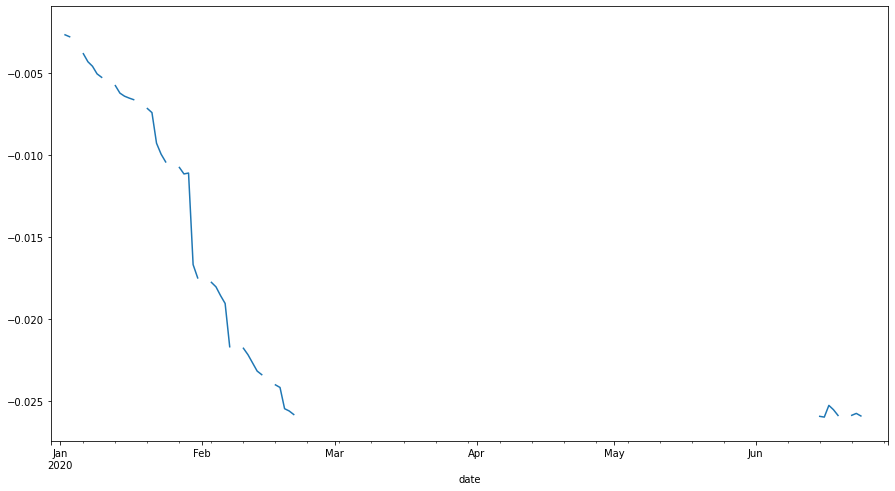

In [96]:
plt.figure(figsize=(15,8))
# sns.lineplot(x=custo_baixo_return.index, y=custo_baixo_return, label='custo baixo')
custo_baixo_return.plot()

Text(0, 0.5, 'retorno')

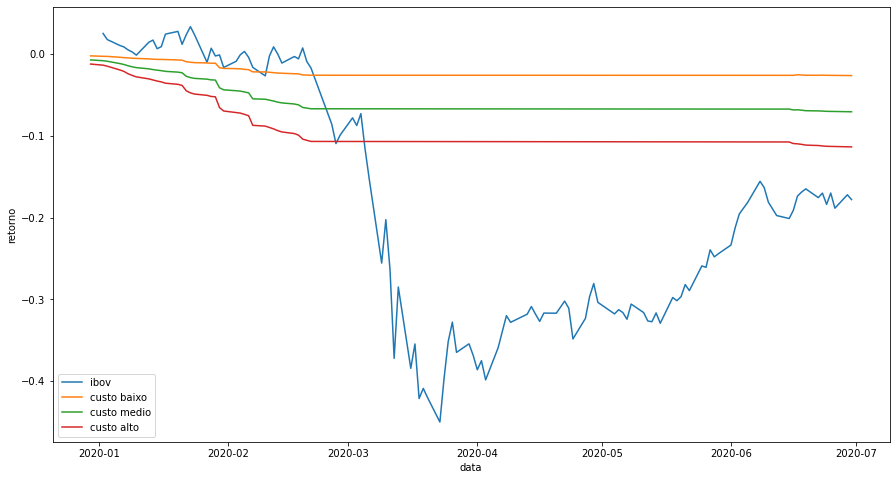

In [97]:
plt.figure(figsize=(15,8))

sns.lineplot(x=ibov_returns.index, y=ibov_returns, label='ibov')
sns.lineplot(x=custo_baixo_return.index, y=custo_baixo_return, label='custo baixo')
sns.lineplot(x=custo_medio_return.index, y=custo_medio_return, label='custo medio')
sns.lineplot(x=custo_alto_return.index, y=custo_alto_return, label='custo alto')

plt.xlabel('data')
plt.ylabel('retorno')
# plt.axhline(y=ibov_returns.iloc[-1])
# plt.axhline(y=ibov_returns.iloc[-1])


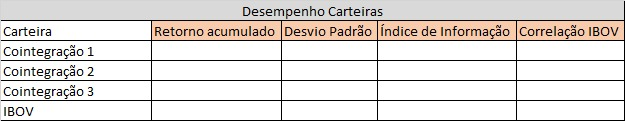

In [68]:
tabela_completa = pd.concat([ibov_returns, custo_baixo_return, custo_medio_return, custo_alto_return], axis=1).fillna(0)
tabela_completa.columns = ['ibov', 'custo_baixo', 'custo_medio', 'custo_alto']
tabela_completa

,ibov,custo_baixo,custo_medio,custo_alto
2019-12-30,0.000000,-0.003389,-0.008363,-0.013411
2019-12-31,0.000000,0.000000,0.000000,0.000000
2020-01-01,0.000000,0.000000,0.000000,0.000000
2020-01-02,0.025319,-0.003591,-0.008600,-0.013683
2020-01-03,0.017830,-0.003668,-0.008697,-0.013799
...,...,...,...,...
2020-06-21,0.000000,0.000000,0.000000,0.000000
2020-06-22,-0.175615,0.001495,-0.005094,-0.011763
2020-06-23,-0.170089,0.001541,-0.005091,-0.011802
2020-06-24,-0.183908,0.001438,-0.005222,-0.011962


In [69]:
vol_ibov = log_return_ibov.std() * math.sqrt(252)
retorno_ibov = ibov_returns.iloc[-1]

sharpe_ibov = retorno_ibov / vol_ibov

sharpe_ibov

-0.27787998528360475

In [70]:
vol_custo_baixo = log_return_custo_baixo.std() * math.sqrt(252)
retorno_custo_baixo = custo_baixo_return.iloc[-1]

sharpe_custo_baixo = retorno_custo_baixo / vol_custo_baixo

corr_baixo_ibov, p_valor = spearmanr(tabela_completa[['ibov', 'custo_baixo']])
corr_baixo_ibov

-0.41851774094934346

In [71]:
vol_custo_medio = log_return_custo_medio.std() * math.sqrt(252)
retorno_custo_medio = custo_medio_return.iloc[-1]
sharpe_custo_medio = retorno_custo_medio / vol_custo_medio

corr_medio_ibov, p_valor = spearmanr(tabela_completa[['ibov', 'custo_medio']])
corr_medio_ibov

-0.37472176810895325

In [72]:
vol_custo_alto = log_return_custo_alto.std() * math.sqrt(252)
retorno_custo_alto = custo_alto_return.iloc[-1]
sharpe_custo_alto = retorno_custo_alto / vol_custo_alto

corr_alto_ibov, p_valor = spearmanr(tabela_completa[['ibov', 'custo_alto']])
corr_alto_ibov

-0.36363231744167057

In [73]:
pd.DataFrame({
    'carteira':['Retorno acumulado', 'Desvio Padrão', 'Índice de Informação', 'Correlação IBOV'], 
    'Cointegração 1':[retorno_custo_baixo, vol_custo_baixo, sharpe_custo_baixo, corr_baixo_ibov],
    'Cointegração 2': [retorno_custo_medio, vol_custo_medio, sharpe_custo_medio, corr_medio_ibov],
    'Cointegração 3': [retorno_custo_alto, vol_custo_alto, sharpe_custo_alto, corr_alto_ibov],
    'IBOV': [retorno_ibov, vol_ibov, sharpe_ibov, '-']
}
            ).T

,0,1,2,3
carteira,Retorno acumulado,Desvio Padrão,Índice de Informação,Correlação IBOV
Cointegração 1,0.000888,0.010568,0.084015,-0.418518
Cointegração 2,-0.006313,0.02006,-0.314707,-0.374722
Cointegração 3,-0.013594,0.030884,-0.440173,-0.363632
IBOV,-0.17002,0.611848,-0.27788,-


# PARTE 2

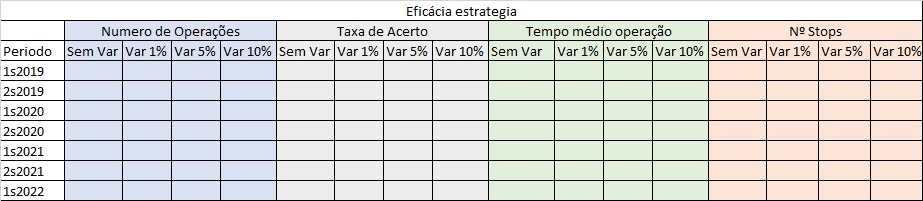

In [182]:
filepath = r'resultados_sergio\diario_252_0.01_0.5_desligado_0.1_desligado_ligado.csv.pickle'

In [183]:
file = filepath[:-11].split('\\')[1].split('_')
dicionario = ['periodo', 'train_size', 'significancia', 'z_score_saida', 'z_score_stop', 'conf_var', 'usar_halflife', 'usar_var']
pd.DataFrame({'-':dicionario, '--':file})

,-,--
0,periodo,diario
1,train_size,252
2,significancia,0.01
3,z_score_saida,0.5
4,z_score_stop,desligado
5,conf_var,0.1
6,usar_halflife,desligado
7,usar_var,ligado


In [184]:
path_sem_var = r'resultados_sergio\diario_252_0.01_0.5_desligado_0.05_desligado_desligado.csv.pickle'
path_var_1 = r'resultados_sergio\diario_252_0.01_0.5_desligado_0.01_desligado_ligado.csv.pickle'
path_var_5 = r'resultados_sergio\diario_252_0.01_0.5_desligado_0.05_desligado_ligado.csv.pickle'
path_var_10 = r'resultados_sergio\diario_252_0.01_0.5_desligado_0.1_desligado_ligado.csv.pickle'

In [185]:
with open(path_sem_var, 'rb') as handle:
    sem_var = desfaz(pickle.load(handle))
    
with open(path_var_1, 'rb') as handle1:
    var1 = desfaz(pickle.load(handle1))

with open(path_var_5, 'rb') as handle5:
    var5 = desfaz(pickle.load(handle5))  
    
with open(path_var_10, 'rb') as handle10:
    var10 = desfaz(pickle.load(handle10)) 


sem_var  = execute.novo_retorno(sem_var.reset_index(), custo_compra=0.00135, custo_venda=0.00385)
var1 = execute.novo_retorno(var1.reset_index(), custo_compra=0.00135, custo_venda=0.00385)
var5 = execute.novo_retorno(var5.reset_index(), custo_compra=0.00135, custo_venda=0.00385)
var10 = execute.novo_retorno(var10.reset_index(), custo_compra=0.00135, custo_venda=0.00385)


C:\Users\willi\Documents\GitHub\cointegration\execute.py:326: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_returns = df_returns.set_index('open_date').loc['2019-01-01':]
C:\Users\willi\Documents\GitHub\cointegration\execute.py:326: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_returns = df_returns.set_index('open_date').loc['2019-01-01':]
C:\Users\willi\Documents\GitHub\cointegration\execute.py:326: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_returns = df_returns.set_index('open_date').loc['2019-01-01':]
C:\Users\willi\Documents\GitHub\cointegration\execute.py:326: FutureWarning: Value based partial slicing on non-monotonic Datetime

In [186]:
fechadas_sem_var = sem_var.loc[sem_var.status == 'close']
fechadas_sem_var['e_lucro_bruto'] = fechadas_sem_var['retorno_acumulado_sem_custos'] > 0

fechadas_var_1 = var1.loc[var1.status == 'close']
fechadas_var_1['e_lucro_bruto'] = fechadas_var_1['retorno_acumulado_sem_custos'] > 0

fechadas_var_5 = var5.loc[var5.status == 'close']
fechadas_var_5['e_lucro_bruto'] = fechadas_var_5['retorno_acumulado_sem_custos'] > 0

fechadas_var_10 = var10.loc[var10.status == 'close']
fechadas_var_10['e_lucro_bruto'] = fechadas_var_10['retorno_acumulado_sem_custos'] > 0

<ipython-input-186-47ec52626802>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fechadas_sem_var['e_lucro_bruto'] = fechadas_sem_var['retorno_acumulado_sem_custos'] > 0
<ipython-input-186-47ec52626802>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fechadas_var_1['e_lucro_bruto'] = fechadas_var_1['retorno_acumulado_sem_custos'] > 0
<ipython-input-186-47ec52626802>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [187]:
eficacia_sem_var = fechadas_sem_var.set_index('open_date').resample('6M',closed='left').agg(
    num_operacoes = ('pair', 'count'),
    taxa_acerto = ('e_lucro_bruto', 'mean'),
    tempo_medio_operacao = ('days_open', 'mean')
)
eficacia_sem_var

,num_operacoes,taxa_acerto,tempo_medio_operacao
open_date,,,
2019-06-30,34,0.911765,22.529412
2019-12-31,11,0.818182,36.818182
2020-06-30,25,0.840000,23.440000
2020-12-31,12,0.833333,20.333333
2021-06-30,17,0.882353,24.411765
2021-12-31,5,0.800000,21.400000
2022-06-30,26,0.846154,21.423077


In [188]:
eficacia_var1 = fechadas_var_1.set_index('open_date').resample('6M',closed='left').agg(
    num_operacoes = ('pair', 'count'),
    taxa_acerto = ('e_lucro_bruto', 'mean'),
    tempo_medio_operacao = ('days_open', 'mean')
)
eficacia_var1

,num_operacoes,taxa_acerto,tempo_medio_operacao
open_date,,,
2019-06-30,38,0.842105,20.815789
2019-12-31,12,0.833333,23.000000
2020-06-30,36,0.722222,12.750000
2020-12-31,14,0.714286,19.714286
2021-06-30,18,0.888889,21.277778
2021-12-31,6,0.666667,23.166667
2022-06-30,33,0.727273,14.121212


In [189]:
fechadas_stop_var1 = fechadas_var_1.loc[(fechadas_var_1.beta_close=='VAR CLOSE')]

fechadas_var1_semestre = fechadas_stop_var1.set_index('open_date').resample('6M',closed='left').agg(
    total_trades = ('status', 'count'),
    gain_var = ('e_lucro_bruto', 'mean'),
)

fechadas_var1_semestre

,total_trades,gain_var
open_date,,
2019-06-30,8,0.500000
2019-12-31,3,0.333333
2020-06-30,20,0.550000
2020-12-31,2,0.000000
2021-06-30,2,0.500000
2021-12-31,1,0.000000
2022-06-30,14,0.428571


In [190]:
eficacia_var5 = fechadas_var_5.set_index('open_date').resample('6M',closed='left').agg(
    num_operacoes = ('pair', 'count'),
    taxa_acerto = ('e_lucro_bruto', 'mean'),
    tempo_medio_operacao = ('days_open', 'mean')
)
eficacia_var5

,num_operacoes,taxa_acerto,tempo_medio_operacao
open_date,,,
2019-06-30,44,0.727273,16.363636
2019-12-31,17,0.647059,14.882353
2020-06-30,39,0.487179,7.000000
2020-12-31,20,0.550000,19.450000
2021-06-30,22,0.636364,20.181818
2021-12-31,8,0.750000,11.000000
2022-06-30,37,0.621622,10.108108


In [191]:
fechadas_stop_var5 = fechadas_var_5.loc[(fechadas_var_5.beta_close=='VAR CLOSE')]

fechadas_var5_semestre = fechadas_stop_var5.set_index('open_date').resample('6M',closed='left').agg(
    total_trades = ('status', 'count'),
    gain_var = ('e_lucro_bruto', 'mean'),
)

fechadas_var5_semestre

,total_trades,gain_var
open_date,,
2019-06-30,28,0.571429
2019-12-31,10,0.400000
2020-06-30,29,0.310345
2020-12-31,9,0.222222
2021-06-30,11,0.363636
2021-12-31,6,0.666667
2022-06-30,24,0.416667


In [192]:
eficacia_var10 = fechadas_var_10.set_index('open_date').resample('6M',closed='left').agg(
    num_operacoes = ('pair', 'count'),
    taxa_acerto = ('e_lucro_bruto', 'mean'),
    tempo_medio_operacao = ('days_open', 'mean')
)
eficacia_var10

,num_operacoes,taxa_acerto,tempo_medio_operacao
open_date,,,
2019-06-30,53,0.603774,10.169811
2019-12-31,18,0.666667,10.388889
2020-06-30,46,0.500000,4.695652
2020-12-31,23,0.521739,14.000000
2021-06-30,24,0.541667,13.625000
2021-12-31,11,0.545455,10.454545
2022-06-30,38,0.552632,8.605263


In [193]:
fechadas_stop_var10 = fechadas_var_10.loc[(fechadas_var_10.beta_close=='VAR CLOSE')]

fechadas_var10_semestre = fechadas_stop_var10.set_index('open_date').resample('6M',closed='left').agg(
    total_trades = ('status', 'count'),
    gain_var = ('e_lucro_bruto', 'mean'),
)

fechadas_var10_semestre

,total_trades,gain_var
open_date,,
2019-06-30,43,0.511628
2019-12-31,15,0.600000
2020-06-30,40,0.425000
2020-12-31,17,0.352941
2021-06-30,17,0.411765
2021-12-31,10,0.500000
2022-06-30,29,0.413793


# descritivas

In [194]:
ibov_returns.describe()

count    120.000000
mean      -0.186974
std        0.148944
min       -0.450300
25%       -0.317318
50%       -0.199399
75%       -0.009064
max        0.033577
Name: close, dtype: float64

In [195]:
ibov_returns

time
2019-12-30         NaN
2020-01-02    0.025319
2020-01-03    0.017830
2020-01-06    0.010662
2020-01-07    0.008794
                ...   
2020-06-19   -0.164927
2020-06-22   -0.175615
2020-06-23   -0.170089
2020-06-24   -0.183908
2020-06-25   -0.170020
Name: close, Length: 121, dtype: float64

In [196]:
# TESTE NORMALIDADE
#perform Kolmogorov-Smirnov test
kstest(ibov_returns.dropna(), 'norm')

KstestResult(statistic=0.4866072735748652, pvalue=1.0610673190883458e-26)

# GRAFICOS

In [98]:
fechadas = custo_baixo.loc[custo_baixo.status=='close']

In [99]:
fechadas['return'].describe()

count    191.000000
mean      -0.001038
std        0.004710
min       -0.014999
25%       -0.005374
50%       -0.000230
75%        0.001910
max        0.014984
Name: return, dtype: float64

In [101]:
fechadas['e_lucro_bruto'] = fechadas['retorno_acumulado_sem_custos'] > 0

<ipython-input-101-501e524d6e9a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fechadas['e_lucro_bruto'] = fechadas['retorno_acumulado_sem_custos'] > 0


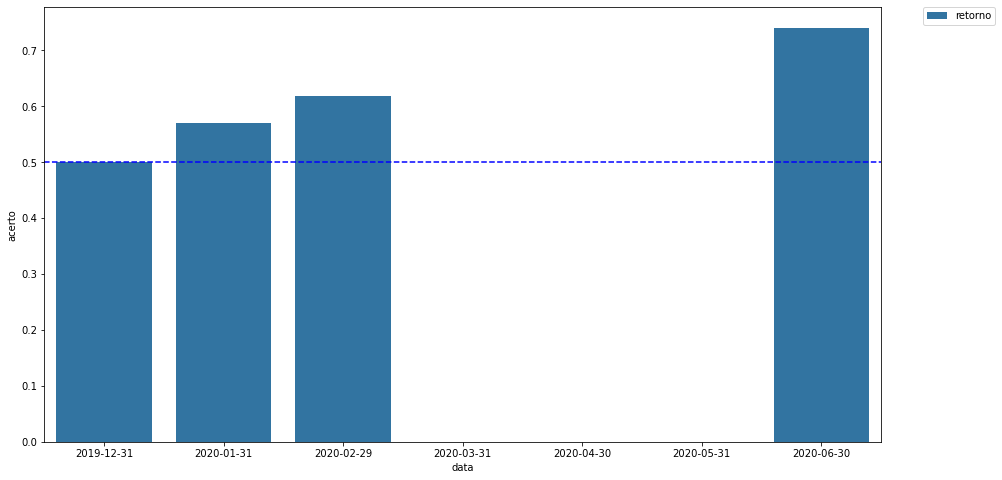

In [102]:
halfyear_accuracy = fechadas.set_index('open_date').resample('1M')[['e_lucro_bruto']].mean().reset_index()
halfyear_accuracy.columns = ['open_date', 'retorno']
halfyear_accuracy['open_date'] = halfyear_accuracy['open_date'].dt.date
halfyear_accuracy = halfyear_accuracy.melt(id_vars='open_date', value_name='acerto')
plt.figure(figsize=(15,8))
sns.barplot(x='open_date', y='acerto', hue='variable', data=halfyear_accuracy)
plt.axhline(y=0.5, color='blue', linestyle='--')
plt.xlabel('data')
# plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Text(0, 0.5, 'acerto')

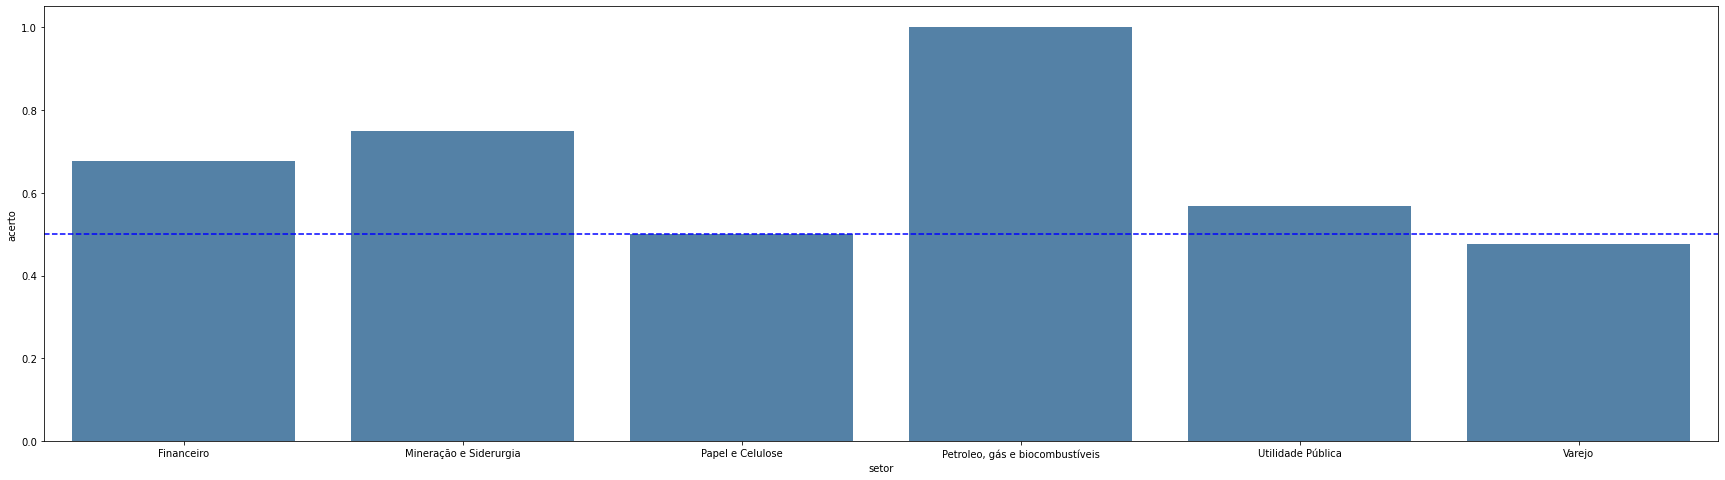

In [103]:
fechadas_agrupadas_semestre = fechadas.groupby('setor').e_lucro_bruto.mean().reset_index()

plt.figure(figsize=(30,8))

# fechadas_agrupadas_semestre['open_date'] = pd.to_datetime(fechadas_agrupadas_semestre['open_date'])
# fechadas_2020 = fechadas_agrupadas_semestre.set_index('open_date').loc['2020'].reset_index()
# fechadas_2020['open_date'] = fechadas_2020.open_date.dt.date

sns.barplot(x='setor', y='e_lucro_bruto', data=fechadas_agrupadas_semestre, color='steelblue')
plt.axhline(y=0.5, color='blue', linestyle='--')

plt.ylabel('acerto')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [104]:
fechadas_agrupadas_semestre = fechadas.groupby('setor').agg(
    operacoes=('return', 'count'),
    retorno = ('return', 'sum'),
    acerto = ('e_lucro_bruto', 'mean')
    )
fechadas_agrupadas_semestre.to_csv('5min var deslitabela')

,operacoes,retorno,acerto
setor,,,
Financeiro,59,-0.137064,0.677966
Mineração e Siderurgia,16,0.003301,0.750000
Papel e Celulose,6,-0.019526,0.500000
"Petroleo, gás e biocombustíveis",1,-0.000636,1.000000
Utilidade Pública,88,0.008297,0.568182
Varejo,21,-0.052601,0.476190


In [80]:
fechadas_grouped = fechadas.groupby('sorted_pair').agg(
    trades = ('sorted_pair','count'),
    taxa_acerto = ('e_lucro_bruto', 'mean'),
    prazo_medio_operacao = ('days_open', 'mean'),
    retorno_bruto_acum = ('retorno_acumulado_sem_custos', 'sum'),
    retorno_liquidi_acum = ('retorno_acumulado', 'sum')
)

fechadas_grouped.sort_values(by=['trades', 'taxa_acerto'], ascending=False).head(15)

,trades,taxa_acerto,prazo_medio_operacao,retorno_bruto_acum,retorno_liquidi_acum
sorted_pair,,,,,
"(GGBR4, GOAU4)",5,0.800000,281.200000,0.063096,0.008909
"(BBDC3, BBDC4)",4,1.000000,399.500000,0.036443,-0.007442
"(CMIG4, ELET6)",3,1.000000,303.333333,0.087517,0.069443
"(KLBN11, SUZB3)",3,1.000000,151.000000,0.079626,0.057181
"(CRFB3, LREN3)",3,0.666667,431.666667,0.047922,0.029871
"(AMER3, MGLU3)",2,1.000000,450.500000,0.046352,0.034244
"(BBAS3, BBDC3)",2,1.000000,591.500000,0.052503,0.022916
"(BBAS3, BBDC4)",2,1.000000,703.500000,0.024332,0.001728
"(CMIG4, ELET3)",2,1.000000,517.500000,0.050512,0.038269


In [81]:
fechadas_grouped.sort_values(by=['trades', 'taxa_acerto'], ascending=False).to_excel('pares_5min_var_desligado.xlsx')

In [86]:
custo_baixo.pivot(index='pair', columns='date', values='return').T.to_excel('15_min_custo_baixo.xlsx')